In [24]:
import numpy as np
import matplotlib.pyplot as plt
import json
%cd /home/u_363747/cs265-mlsys-2024/stats

/home/u_363747/cs265-mlsys-2024/stats


In [7]:
models_batches = {
    'hf_Bert': [4, 6, 8, 10],
    'resnet50': [32, 64, 96, 128]
}

In [14]:
def plot_peak_mem(model_name, ymax):
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    batch_sizes = models_batches[model_name]
    for mode in range(2):
        peak_mems = []
        for batch_size in batch_sizes:
            with open(f'stats_{mode}_{model_name}_{batch_size}.json') as f:
                stats = json.load(f)
            peak_mems.append(stats['max_peak_memory'])
        peak_mems = np.array(peak_mems)
        batch_sizes = np.array(batch_sizes)
        axes[mode].bar(batch_sizes.astype(str), peak_mems/2**30)
        axes[mode].set_xlabel('Batch size')
        axes[mode].set_ylabel('Peak memory consumption (GB)')
        axes[mode].set_ylim(0, ymax)
        axes[mode].set_title(('No' if mode == 0 else 'Using') + ' activation checkpointing')
    fig.suptitle(('BERT' if model_name == 'hf_Bert' else 'ResNet-50') +
                 ': Peak memory consumption vs. batch size')

In [15]:
def plot_iteration_latency(model_name, ymax):
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    batch_sizes = models_batches[model_name]
    for mode in range(2):
        runtimes = []
        for batch_size in batch_sizes:
            with open(f'stats_{mode}_{model_name}_{batch_size}.json') as f:
                stats = json.load(f)
            runtimes.append(stats['iteration_latency'])
        runtimes = np.array(runtimes)
        batch_sizes = np.array(batch_sizes)
        axes[mode].bar(batch_sizes.astype(str), runtimes/1000)
        axes[mode].set_xlabel('Batch size')
        axes[mode].set_ylabel('Iteration latency (seconds)')
        axes[mode].set_ylim(0, ymax)
        axes[mode].set_title(('No' if mode == 0 else 'Using') + ' activation checkpointing')
    fig.suptitle(('BERT' if model_name == 'hf_Bert' else 'ResNet-50') +
                 ': Iteration latency vs. batch size')

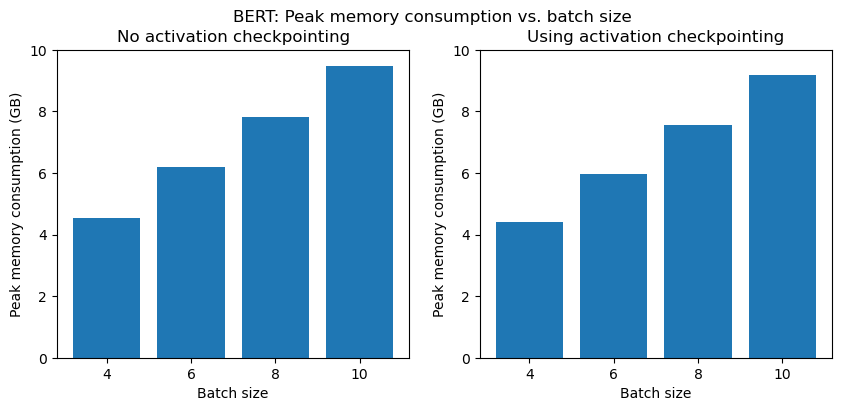

In [25]:
plot_peak_mem('hf_Bert', 10)

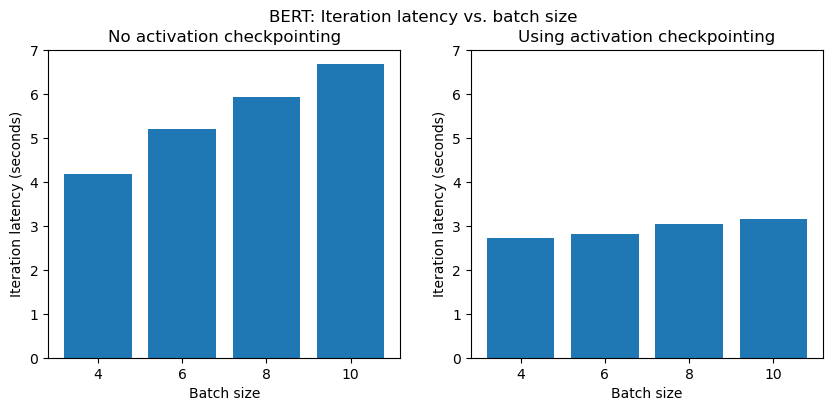

In [6]:
plot_iteration_latency('hf_Bert', 7)

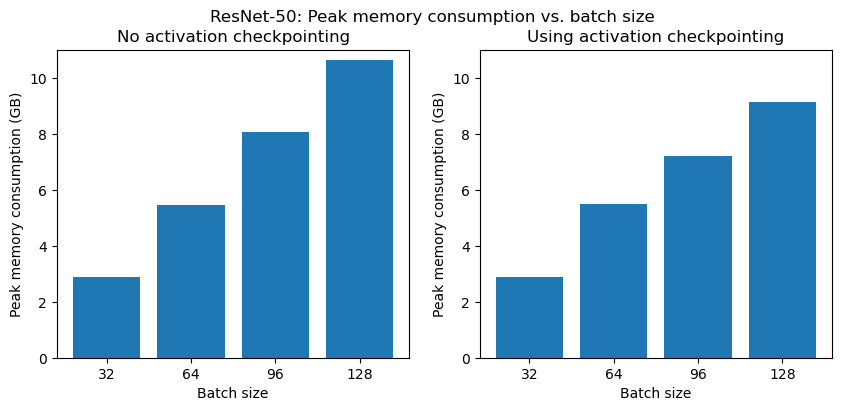

In [8]:
plot_peak_mem('resnet50', 11)

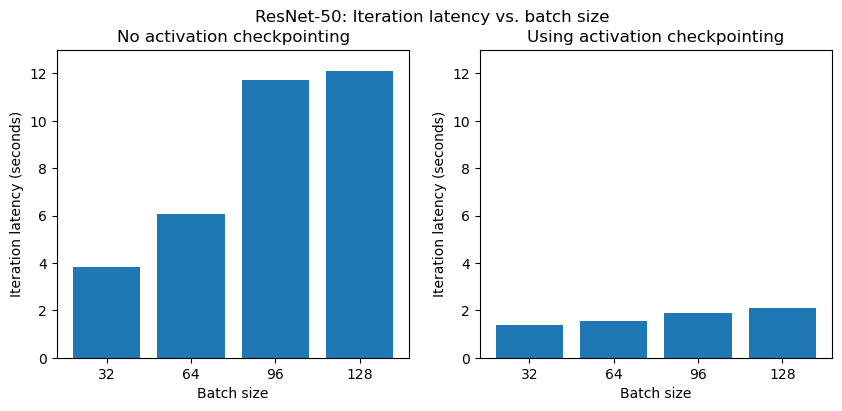

In [13]:
plot_iteration_latency('resnet50', 13)

In [52]:
def plot_nodes(model_name, ymax1, ymax2):
    fig, axes = plt.subplots(2, 2, figsize=(10,8))
    batch_size = max(models_batches[model_name])
    for mode in range(2):
        with open(f'stats_{mode}_{model_name}_{batch_size}.json') as f:
            stats = json.load(f)
        runtimes = [node['runtime'] + node.get('swap_time', 0) for node in stats['nodes']]
        axes[0][mode].plot(range(len(runtimes)), runtimes)
        axes[0][mode].set_xlabel('Node')
        axes[0][mode].set_ylabel('Runtime (milliseconds)')
        axes[0][mode].set_ylim(0, ymax1)
        axes[0][mode].set_title('Runtimes (+ swap times),\n' +
                                ('no' if mode == 0 else 'using') + ' activation checkpointing')
        param_mem = np.array([
            node['param_and_opt_state_memory'] if 'param_and_opt_state_memory' in node else 0
            for node in stats['nodes']
        ])
        grad_mem = np.array([
            node['grad_memory'] if 'grad_memory' in node else 0
            for node in stats['nodes']
        ])
        act_mem = np.array([
            node['activation_memory'] if 'activation_memory' in node else 0
            for node in stats['nodes']
        ])
        other_mem = np.array([
            node['other_memory'] if 'grad_memory' in node else 0
            for node in stats['nodes']
        ])
        node_idxs = range(len(stats['nodes']))
        axes[1][mode].plot(node_idxs, param_mem/2**30, label='parameter')
        axes[1][mode].plot(node_idxs, grad_mem/2**30, label='gradient')
        axes[1][mode].plot(node_idxs, act_mem/2**30, label='activation')
        axes[1][mode].plot(node_idxs, other_mem/2**30, label='other')
        axes[1][mode].set_xlabel('Node')
        axes[1][mode].set_ylabel('Memory (GB)')
        axes[1][mode].set_ylim(0, ymax2)
        axes[1][mode].set_title('Memory breakdown,\n' +
                                ('no' if mode == 0 else 'using') + ' activation checkpointing')
        axes[1][mode].legend()
    fig.suptitle(('BERT' if model_name == 'hf_Bert' else 'ResNet-50') +
                 f': Node-level analysis (batch size {batch_size})')
    fig.tight_layout()

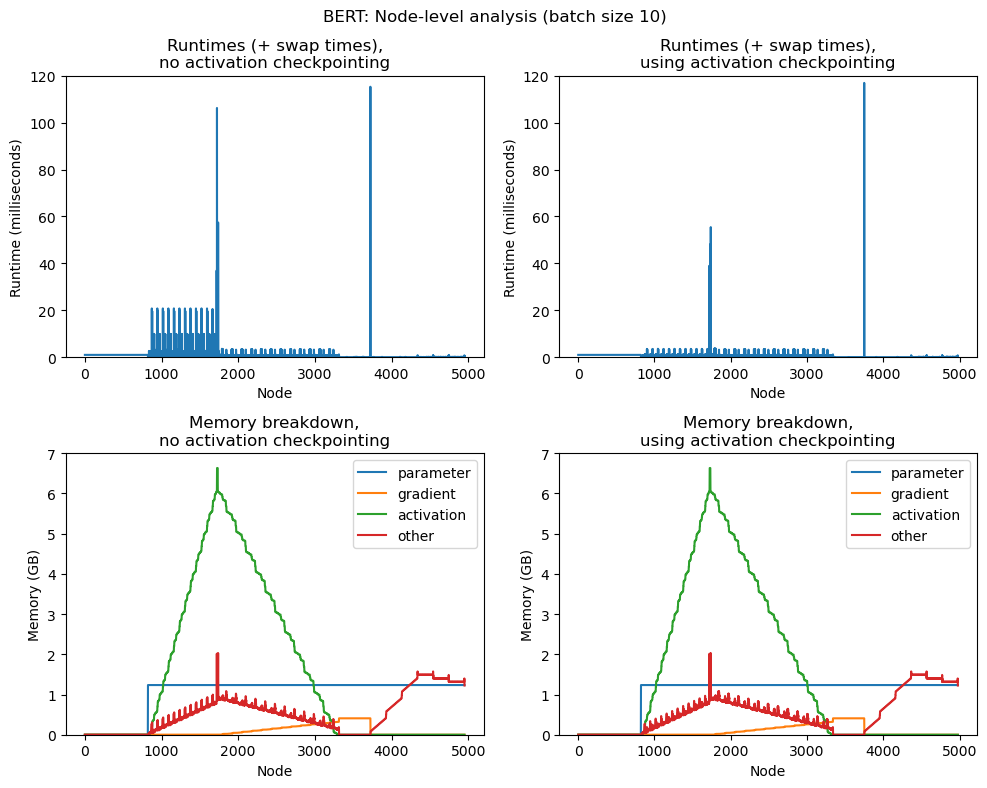

In [53]:
plot_nodes('hf_Bert', 120, 7)

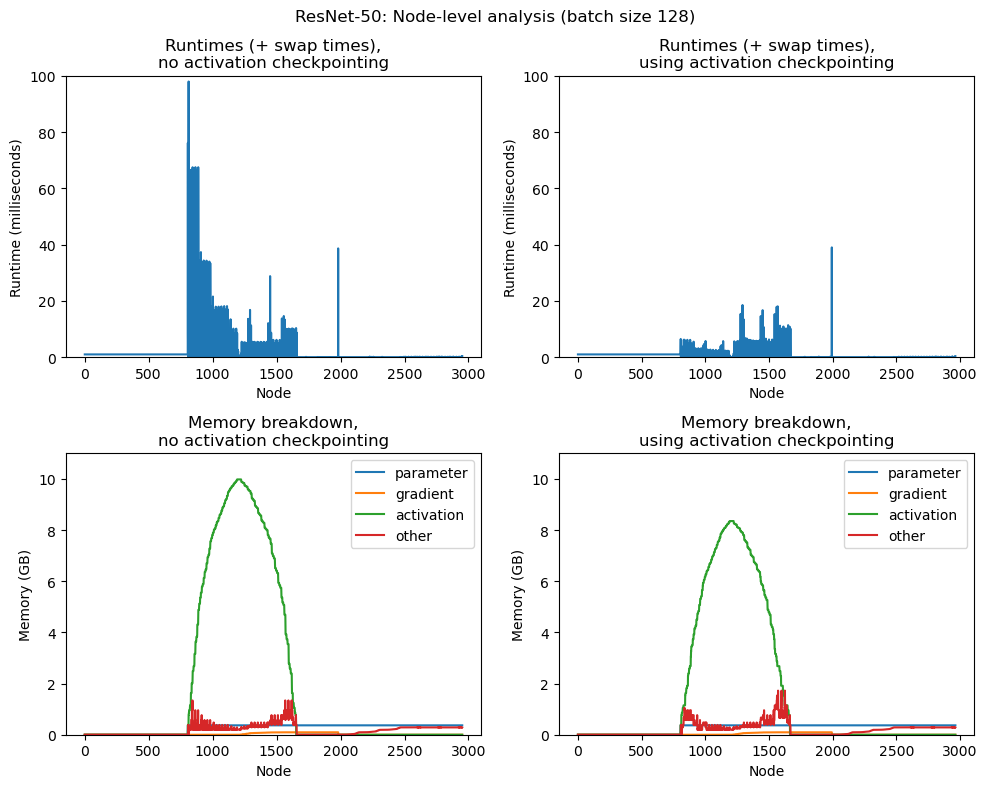

In [57]:
plot_nodes('resnet50', 100, 11)

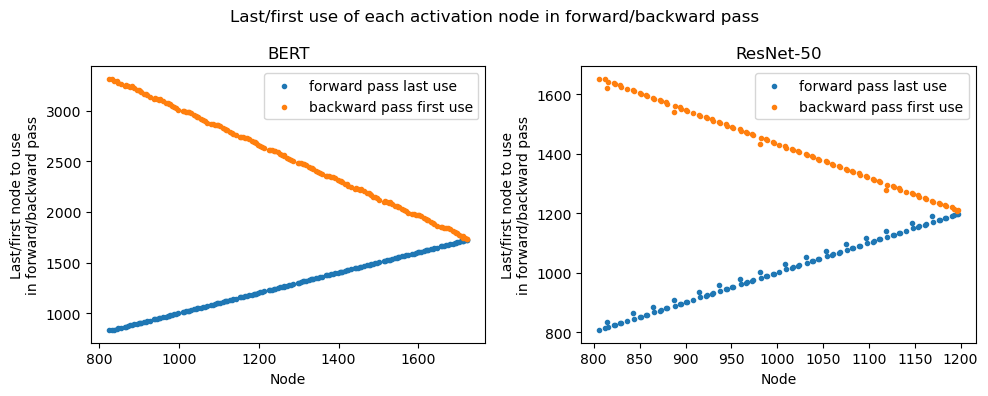

In [67]:
def plot_last_first_use():
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    for i, model_name in enumerate(models_batches.keys()):
        batch_size = max(models_batches[model_name])
        with open(f'stats_0_{model_name}_{batch_size}.json') as f:
            stats = json.load(f)
        node_idxs = {n['node_name']: i for i, n in enumerate(stats['nodes'])}
        activation_idxs = [i for i, n in enumerate(stats['nodes']) if n['node_type'] == 'activation']
        forward_last_idxs = [node_idxs[stats['nodes'][i]['last_forward']] for i in activation_idxs]
        backward_first_idxs = [node_idxs[stats['nodes'][i]['first_backward']] for i in activation_idxs]
        axes[i].scatter(activation_idxs, forward_last_idxs, marker='.', label='forward pass last use')
        axes[i].scatter(activation_idxs, backward_first_idxs, marker='.', label='backward pass first use')
        axes[i].set_xlabel('Node')
        axes[i].set_ylabel('Last/first node to use\nin forward/backward pass')
        axes[i].set_title('BERT' if model_name == 'hf_Bert' else 'ResNet-50')
        axes[i].legend()
    fig.suptitle('Last/first use of each activation node in forward/backward pass')
    fig.tight_layout()
plot_last_first_use()